# Capstone Project - Analysis of the Corona pandemic
In this project, the data from the ongoing "Corona" pandemic is analyzed. The SARS-CoV-2 virus has spread around the world in a relatively short time after its first apperance in Wuhan (China) and the caused disease COVID-19 (=coronavirus disease 2019) stresses the healthcare systems in many countries. Here it is analyzed what are the driving forces for the exponential growths rates and how effective are the measures against.

Therefor, two datasets are analyzed:

1. One dataset has been taken from the CSSE at Johns Hopkins University: It shows timeseries regarding cumulative Corona cases of all affacted countries. The data has been taken from the following GitHub repository. Please note, that the data is updated every day. Thus, there might be effects on the conclusion in a few weeks. For this analysis, data taken on April 14th has been used (stored in DataScience_Project4 GitHub): https://github.com/CSSEGISandData/COVID-19/edit/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv

2. Another dataset has been downloaded from Kaggle. It gives an overview on different Corona-related information for the affected countries: https://www.kaggle.com/koryto/countryinfo#covid19countryinfo.csv

## 1. Questions
The main questions are:
1. What are the effects of the initial situation in the different countries on the exponential growth rate?
2. What are the effects of the different measures to contain the disease?

To answer these questions, it is - after a general data understanding - checked for correlations between measures in the data. In a second step it is checked whether it is possible to predict growth and containment.


## 2. Data understanding
The data is loaded and a number of things are checked to understand the datasets.


In [1]:
# Import standard packages
import numpy as np
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from IPython import display
%matplotlib inline

# Import additional packages
from scipy.signal import savgol_filter # Implements specific filter (Savitzky-Golay) to smooth statistical fluctuations
import capstone_support_functions as capstone

# Import helper functions stored in 

# Set output options in a way that all columns and rows of the used datasets are visible
pd.set_option('display.max_columns', 1000)
pd.set_option("display.max_rows", 1000)

df_timeseries = pd.read_csv('./time_series_covid19_confirmed_global.csv') # Read in timeseries data
df_countryinfo = pd.read_csv('./covid19countryinfo.csv') # Read in country information data

#df_tests = pd.read_csv('./covid19tests.csv') # Read in data

### Check the timeseries data

In [2]:
# Show the timeseries data
df_timeseries

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170,174,237,273,281
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223,243,259,277,304
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584,716,847,986,1171
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370,376,390,428,439
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7,7,8,8,8
5,NaN,Antigua and Barbuda,17.060800,-61.796400,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,3,3,3,7,7,7,7,7,7,7,9,15
6,NaN,Argentina,-38.416100,-63.616700,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,8,12,12,17,19,19,31,34,45,56,68,79,97,128,158,266,301,387,387,502,589,690,745,820,1054,1054,1133,1265
7,NaN,Armenia,40.069100,45.038200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,4,8,18,26,52,78,84,115,136,160,194,235,249,265,290,329,407,424,482,532,571,663,736
8,Australian Capital Territory,Australia,-35.473500,149.012400,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,2,3,4,6,9,19,32,39,39,53,62,71,77,78,80,84,87,91
9,New South Wales,Australia,-33.868800,151.209300,0,0,0,0,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,6,6,13,22,22,26,28,38,48,55,65,65,92,112,134,171,210,267,307,353,436,669,669,818,1029,1219,1405,1617,1791,2032,2032,2182,2298,2389


In [3]:
print('The dataset contains', df_timeseries.shape[0], 'rows and', df_timeseries.shape[1], 'columns.')

The dataset contains 258 rows and 77 columns.


The timeseries contains the number of Corona cases for 258 countries/regions for a time period beginning on January 22, 2020. In some cases, there is a differentiation between different provinces/states of a country. Furthermore, the latitutde and longitude of the countries are shown.

In the next step, the number of cases are plotted. Thereby, the 20 countries with the highest number of cases at the end of the timeseries are shown.

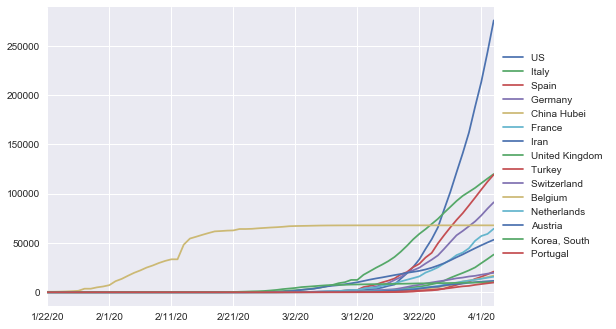

In [4]:
# Sort the timeseries according the number of cases in the last column (last known day)
df_sorted=df_timeseries.sort_values(by=df_timeseries.columns[-1], ascending=False)

# Select the first rows which shall be plot
df_sorted=df_sorted.head(15)

# Remove nan values
df_sorted['Province/State'].fillna("", inplace=True)

# Add a column country that combines Country/Region and Province/State
df_sorted['Country']=df_sorted['Country/Region']+" "+df_sorted['Province/State']

# Define the country column as the new index (later on shown in the plot legend)
df_sorted.set_index('Country', inplace=True)

# Delete columns which are not needed for the plot
del df_sorted['Country/Region']
del df_sorted['Province/State']
del df_sorted['Lat']
del df_sorted['Long']
        
# Exchange rows and columns which is required for the plot function (in line charts columns are plotted)
df_sorted=df_sorted.transpose()
    
# Create plot
plt.style.use('seaborn') # Define style  
df_sorted.plot(kind='line', legend=True, logy=False, mark_right=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) # Show legend outside of the plot
plt.show()

The plot above shows the typical chart maybe known from news coverage. It shows typical exponential growth curves for most of the countries. After some days, the growth seems to change to a more linear growth. Two curves have a very specific shape. The US curves shows the highest growth rate while for China the growth has stopped after a second steep increase mid of February.

### Check the country information data

In [5]:
# Show countryinfo
df_countryinfo

,region,country,alpha3code,alpha2code,pop,tests,testpop,density,medianage,urbanpop,quarantine,schools,publicplace,gatheringlimit,gathering,nonessential,hospibed,smokers,sex0,sex14,sex25,sex54,sex64,sex65plus,sexratio,lung,femalelung,malelung,gdp2019,healthexp,healthperpop,fertility,firstcase,totalcases,active30,active31,newcases30,newcases31,deaths,newdeaths30,newdeaths31,recovered,critical30,critical31,casediv1m,deathdiv1m
0,NaN,Afghanistan,AFG,AF,"38,928,346",NaN,NaN,60.0,18.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN,0.5000,NaN,1.05,1.03,1.03,1.03,0.97,0.85,1.03,37.62,36.31,39.33,"18,734",184,4.726633,5.12,2/23/2020,174,139,165,25,4,4,NaN,NaN,5,NaN,NaN,4,0.10
1,NaN,Albania,ALB,AL,"2,877,797",NaN,NaN,105.0,36.0,63.0,NaN,NaN,NaN,NaN,NaN,NaN,2.9000,29.40,1.08,1.11,1.09,0.93,0.95,0.87,0.98,11.67,7.02,17.04,"15,418",774,268.955733,1.51,3/7/2020,243,168,176,11,20,15,1.0,4.0,52,7,8,84,5.00
2,NaN,Algeria,DZA,DZ,"43,851,044",NaN,NaN,18.0,29.0,73.0,NaN,NaN,NaN,NaN,NaN,NaN,1.9000,NaN,1.05,1.05,1.05,1.03,1.01,0.89,1.03,8.77,5.03,12.81,"172,781","1,031",23.511413,2.70,2/24/2020,716,449,626,NaN,132,44,NaN,9.0,46,NaN,NaN,16,1.00
3,NaN,Andorra,AND,AD,"77,265",NaN,NaN,164.0,45.0,88.0,NaN,NaN,NaN,NaN,NaN,NaN,2.5000,32.50,1.07,1.05,1.08,1.05,1.15,1.02,1.06,NaN,NaN,NaN,"91,527","5,949",76994.758300,1.40,3/1/2020,370,322,352,NaN,NaN,8,NaN,NaN,10,10,10,"4,789",104.00
4,NaN,Antigua and Barbuda,ATG,AG,"97,929",NaN,NaN,223.0,34.0,26.0,NaN,NaN,NaN,NaN,NaN,NaN,3.8000,NaN,1.05,1.03,0.99,0.84,0.82,0.76,0.90,11.76,7.67,18.78,"1,688","1,105",11283.685120,2.00,3/12/2020,7,7,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71,NaN
5,NaN,Argentina,ARG,AR,"45,195,774",NaN,NaN,17.0,32.0,93.0,3/20/2020,NaN,NaN,NaN,NaN,NaN,5.0000,23.95,1.05,1.06,1.05,1.00,0.94,0.71,0.98,29.27,20.16,42.59,"445,469","1,390",30.755088,2.26,3/2/2020,966,570,700,NaN,146,26,2.0,3.0,240,NaN,NaN,21,0.60
6,NaN,Armenia,ARM,AM,"2,963,243",694.0,4269.802594,104.0,35.0,63.0,NaN,NaN,NaN,NaN,NaN,NaN,4.2000,26.90,1.13,1.14,1.06,0.93,0.84,0.67,0.94,23.86,16.17,35.99,"13,444",883,297.984337,1.64,2/29/2020,532,449,499,58,50,3,NaN,NaN,30,15,30,180,1.00
7,Aruba,Netherlands,ABW,AW,"106,766",NaN,NaN,593.0,41.0,44.0,NaN,NaN,NaN,NaN,NaN,NaN,1.2000,NaN,1.02,1.01,1.01,0.93,0.87,0.64,0.90,NaN,NaN,NaN,"2,903",43,402.749939,1.83,3/12/2020,55,49,54,NaN,5,NaN,NaN,NaN,1,NaN,NaN,515,NaN
8,NaN,Australia,AUS,AU,"25,499,884",31635.0,806.065560,3.0,38.0,86.0,NaN,NaN,3/23/2020,2.0,3/29/2020,NaN,3.8000,14.90,1.06,1.06,1.09,0.99,0.93,0.86,0.99,18.79,15.90,22.16,"1,376,255","4,492",176.157664,1.77,1/24/2020,"4,561","3,983","4,205",82,101,19,1.0,NaN,337,28,28,179,0.70
9,NaN,Austria,AUT,AT,"9,006,398",10278.0,876.279237,109.0,43.0,57.0,3/16/2020,NaN,NaN,NaN,NaN,NaN,7.6000,35.15,1.05,1.05,1.04,1.00,0.98,0.76,0.96,17.02,13.02,22.14,"447,718","5,138",570.483339,1.47,2/24/2020,"10,109","8,710","8,886",666,491,128,22.0,20.0,"1,095",193,198,"1,122",14.00


---

# EXPERIMENTATION AND DRAFT

In [6]:
df_countryinfo.columns

Index(['region', 'country', 'alpha3code', 'alpha2code', 'pop', 'tests',
       'testpop', 'density', 'medianage', 'urbanpop', 'quarantine', 'schools',
       'publicplace', 'gatheringlimit', 'gathering', 'nonessential',
       'hospibed', 'smokers', 'sex0', 'sex14', 'sex25', 'sex54', 'sex64',
       'sex65plus', 'sexratio', 'lung', 'femalelung', 'malelung', 'gdp2019',
       'healthexp', 'healthperpop', 'fertility', 'firstcase', 'totalcases',
       'active30', 'active31', 'newcases30', 'newcases31', 'deaths',
       'newdeaths30', 'newdeaths31', 'recovered', 'critical30', 'critical31',
       'casediv1m', 'deathdiv1m'],
      dtype='object')

In [7]:
df_countryinfo.shape[0]

249

In [8]:
#df_info=df_countryinfo.merge(df_tests, on=['region', 'country'])

In [9]:
#df_info

In [10]:
#df_info.shape[0]

## Create timeseries dataset to overlay the rates of increase for all countries

In [11]:
df_timeseries['Province/State'].fillna("", inplace=True)

In [12]:
df_timeseries.head(10)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20
0,,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170,174,237,273,281
1,,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223,243,259,277,304
2,,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584,716,847,986,1171
3,,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370,376,390,428,439
4,,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7,7,8,8,8
5,,Antigua and Barbuda,17.0608,-61.7964,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,3,3,3,7,7,7,7,7,7,7,9,15
6,,Argentina,-38.4161,-63.6167,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,8,12,12,17,19,19,31,34,45,56,68,79,97,128,158,266,301,387,387,502,589,690,745,820,1054,1054,1133,1265
7,,Armenia,40.0691,45.0382,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,4,8,18,26,52,78,84,115,136,160,194,235,249,265,290,329,407,424,482,532,571,663,736
8,Australian Capital Territory,Australia,-35.4735,149.0124,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,2,3,4,6,9,19,32,39,39,53,62,71,77,78,80,84,87,91
9,New South Wales,Australia,-33.8688,151.2093,0,0,0,0,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,6,6,13,22,22,26,28,38,48,55,65,65,92,112,134,171,210,267,307,353,436,669,669,818,1029,1219,1405,1617,1791,2032,2032,2182,2298,2389


In [13]:
# Create a new data frame to overlay the rates of increase for all countries 
df_growth = pd.DataFrame()

In [14]:
# Add a column for countries that combines columns for country/region and province/state from original dataset
df_growth['Country']=df_timeseries['Country/Region']+" "+df_timeseries['Province/State']

In [15]:
# Iterate over all rows in df and fill the user item data frame
for index, row in df_timeseries.iterrows():
    
    # Iterate over all columns
    counter=0
    new_column=1
    for col_name, col_data in df_timeseries.iteritems():
        counter=counter+1
        if counter>4:
            if df_timeseries.at[index, col_name]>100 or new_column>1:
                df_growth.at[index, str(new_column)]=df_timeseries.at[index, col_name]
                new_column=new_column+1


In [16]:
df_growth.set_index('Country', inplace=True)

In [17]:
df_growth.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,110.0,110.0,120.0,170.0,174.0,237.0,273.0,281.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Albania,104.0,123.0,146.0,174.0,186.0,197.0,212.0,223.0,243.0,259.0,277.0,304.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Algeria,139.0,201.0,230.0,264.0,302.0,367.0,409.0,454.0,511.0,584.0,716.0,847.0,986.0,1171.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Andorra,113.0,133.0,164.0,188.0,224.0,267.0,308.0,334.0,370.0,376.0,390.0,428.0,439.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
def sort_according_to_number_of_infections(df):
    '''
    INPUT:
    df - pandas dataframe with timeseries of number of infections
    
    OUTPUT:
    df - pandas dataframe in which the rows are sorted according to the number of infections
    
    Description:
    Sorts the rows in a descending manner according the number of infections
    '''

    # Sort according to the number of infections
    # Iterate over all rows in df and fill the user item data frame
    for index, row in df.iterrows():
    
        # Iterate over all columns
        infections=0
        for col_name, col_data in df.iteritems():
            if df.at[index, col_name]>infections:
                infections=df.at[index, col_name]
                
        df.at[index, 'Infections']=infections
        df=df.sort_values(by='Infections', ascending=False)
        #del df['Infections']
        
    return df



# Create a line plot

def lineplot(df, number_of_top_countries):
    '''
    INPUT:
    df - pandas dataframe with timeseries of number of infections
    number_of_top_countries - plot only the specified number of countries with highest number of infections
    
    OUTPUT:
    n/a
    
    Description:
    Creates a line plot of Corona case data. The x-axis shows the days. The y-axis shows the number of cases.
    '''

    # Select the first rows according to value of number_of_top_countries
    df=df.head(number_of_top_countries)

    del df['Infections']
        
    # Exchange rows and columns
    df=df.transpose()
    
    # Create plot
    plt.style.use('seaborn')    
    df.plot(kind='line', legend=True, logy=False, mark_right=True)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) # Show legend outside of the plot
    plt.show()

In [19]:
df_growth_sorted=sort_according_to_number_of_infections(df_growth)

In [20]:
df_growth_sorted.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,Infections
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
US,118.0,149.0,217.0,262.0,402.0,518.0,583.0,959.0,1281.0,1663.0,2179.0,2727.0,3499.0,4632.0,6421.0,7783.0,13677.0,19100.0,25489.0,33276.0,43847.0,53740.0,65778.0,83836.0,101657.0,121478.0,140886.0,161807.0,188172.0,213372.0,243453.0,275586.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,275586.0
Italy,155.0,229.0,322.0,453.0,655.0,888.0,1128.0,1694.0,2036.0,2502.0,3089.0,3858.0,4636.0,5883.0,7375.0,9172.0,10149.0,12462.0,12462.0,17660.0,21157.0,24747.0,27980.0,31506.0,35713.0,41035.0,47021.0,53578.0,59138.0,63927.0,69176.0,74386.0,80589.0,86498.0,92472.0,97689.0,101739.0,105792.0,110574.0,115242.0,119827.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,119827.0
Spain,120.0,165.0,222.0,259.0,400.0,500.0,673.0,1073.0,1695.0,2277.0,2277.0,5232.0,6391.0,7798.0,9942.0,11748.0,13910.0,17963.0,20410.0,25374.0,28768.0,35136.0,39885.0,49515.0,57786.0,65719.0,73235.0,80110.0,87956.0,95923.0,104118.0,112065.0,119199.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,119199.0
Germany,130.0,159.0,196.0,262.0,482.0,670.0,799.0,1040.0,1176.0,1457.0,1908.0,2078.0,3675.0,4585.0,5795.0,7272.0,9257.0,12327.0,15320.0,19848.0,22213.0,24873.0,29056.0,32986.0,37323.0,43938.0,50871.0,57695.0,62095.0,66885.0,71808.0,77872.0,84794.0,91159.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91159.0
China Hubei,444.0,444.0,549.0,761.0,1058.0,1423.0,3554.0,3554.0,4903.0,5806.0,7153.0,11177.0,13522.0,16678.0,19665.0,22112.0,24953.0,27100.0,29631.0,31728.0,33366.0,33366.0,48206.0,54406.0,56249.0,58182.0,59989.0,61682.0,62031.0,62442.0,62662.0,64084.0,64084.0,64287.0,64786.0,65187.0,65596.0,65914.0,66337.0,66907.0,67103.0,67217.0,67332.0,67466.0,67592.0,67666.0,67707.0,67743.0,67760.0,67773.0,67781.0,67786.0,67790.0,67794.0,67798.0,67799.0,67800.0,67800.0,67800.0,67800.0,67800.0,67800.0,67801.0,67801.0,67801.0,67801.0,67801.0,67801.0,67801.0,67801.0,67802.0,67802.0,67802.0,67802.0


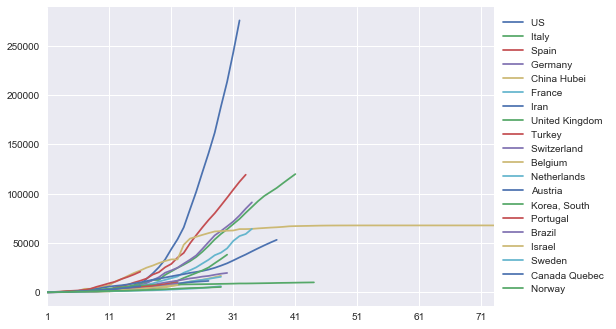

In [21]:
lineplot(df_growth_sorted, 20)

In [22]:
def savitzky_golay_filter(df):
    '''
    INPUT:
    df - pandas dataframe with timeseries
    
    OUTPUT:
    df - pandas dataframe which which is the filtered input dataframe
    
    Description:
    In the derivative for a timeseries, datapoint x is the differences of point x and x-1 from the input array.
    '''

    df_output=df.copy()
    
    # Sort according to the number of infections
    # Iterate over all rows in df and fill the user item data frame
    for index, row in df.iterrows():
        
        value_list=[]
        
        # Iterate over all columns
        for col_name, col_data in df.iteritems():
            if col_name!='Infections' and not(np.isnan(df_output.at[index, col_name])):
                value_list.append(df_output.at[index, col_name])
        
        if len(value_list) >= 5:
            value_list=savgol_filter(value_list, 5, 2)

        value_liste_iterator=iter(value_list)
        
        # Iterate over all columns
        for col_name, col_data in df.iteritems():
            if col_name!='Infections' and not(np.isnan(df_output.at[index, col_name])):
                df_output.at[index, col_name]=next(value_liste_iterator)                
                
    return df_output
    

In [23]:
df_growth_sorted_filtered=savitzky_golay_filter(df_growth_sorted)

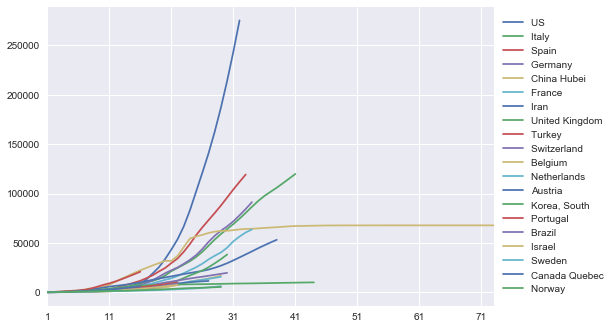

In [24]:
lineplot(df_growth_sorted_filtered, 20)

In [25]:
def derivative(df):
    '''
    INPUT:
    df - pandas dataframe with timeseries
    
    OUTPUT:
    df - pandas dataframe which represents a derivative of the input dataframe
    
    Description:
    In the derivative for a timeseries, datapoint x is the differences of point x and x-1 from the input array.
    '''

    df_output=df.copy()
    
    # Sort according to the number of infections
    # Iterate over all rows in df and fill the user item data frame
    for index, row in df.iterrows():
    
        # Iterate over all columns
        increase=0
        last_col_name=0
        for col_name, col_data in df.iteritems():
            if col_name!='Infections':
                if last_col_name != 0:
                    df_output.at[index, col_name]=df.at[index, col_name]-df.at[index, last_col_name]
                    last_col_name=col_name
                else:
                    df_output.at[index, col_name]=0
                    last_col_name=col_name
        
    return df_output


In [26]:
df_derivative=derivative(df_growth_sorted_filtered)

In [27]:
df_derivative.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,Infections
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
US,0.0,26.314286,54.171429,80.571429,111.800000,90.542857,160.657143,272.628571,366.485714,393.657143,475.714286,577.914286,753.742857,1264.657143,1153.000000,2733.771429,4488.114286,6061.142857,6221.085714,8284.314286,9616.742857,10341.542857,12996.628571,16461.485714,18947.628571,19050.514286,19608.057143,21996.285714,24376.857143,27045.428571,29456.542857,31801.828571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,275586.0
Italy,0.0,59.400000,101.400000,138.457143,194.371429,204.971429,343.885714,414.542857,449.057143,430.428571,612.542857,694.685714,890.885714,1164.028571,1617.914286,1414.200000,1755.800000,858.857143,2191.714286,3217.742857,4434.457143,3303.371429,3349.742857,3499.600000,4286.800000,5215.457143,6143.114286,6276.800000,5627.628571,5023.428571,4969.485714,5540.000000,5863.142857,6151.314286,5837.457143,5116.885714,4223.485714,4149.428571,4572.600000,4630.457143,4766.171429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,119827.0
Spain,0.0,28.542857,53.114286,73.428571,95.742857,118.771429,190.057143,408.400000,623.971429,208.371429,1060.028571,1662.171429,1874.714286,1407.771429,1858.314286,1885.542857,2665.400000,2968.542857,3803.857143,3520.485714,4916.971429,4634.000000,6791.828571,7915.628571,8987.657143,7851.142857,7346.200000,7243.400000,7552.942857,8099.000000,8152.657143,7726.085714,7452.657143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,119199.0
Germany,0.0,-7.371429,51.342857,101.571429,179.714286,184.657143,179.228571,167.714286,195.314286,302.514286,225.142857,682.657143,1003.600000,1263.228571,1099.085714,1471.685714,2162.857143,2683.171429,3685.914286,3545.200000,2998.085714,2812.057143,3716.714286,4035.000000,4769.171429,6155.228571,7226.228571,6222.542857,5102.857143,4418.342857,5142.085714,6050.371429,6420.685714,6955.257143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91159.0
China Hubei,0.0,4.285714,104.428571,209.514286,150.428571,991.571429,1019.114286,1084.457143,666.714286,1018.028571,2026.885714,2872.428571,3229.228571,2806.371429,2927.342857,2732.171429,2482.028571,2495.171429,2300.514286,2263.885714,25.628571,4938.428571,9035.342857,8565.628571,2256.742857,1513.771429,1933.000000,1360.600000,717.142857,127.714286,705.400000,713.485714,495.514286,113.428571,414.400000,461.428571,366.142857,356.485714,458.057143,452.057143,283.600000,101.657143,113.285714,131.6,119.142857,78.628571,45.371429,29.914286,20.857143,11.371429,8.257143,5.085714,4.0,4.171429,3.228571,1.857143,0.485714,0.257143,-0.085714,0.0,-0.085714,0.342857,0.485714,0.342857,-0.085714,0.0,0.0,0.0,-0.085714,0.342857,0.485714,0.228571,0.085714,67802.0


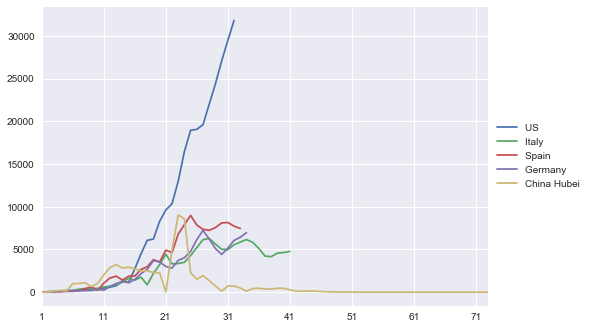

In [28]:
lineplot(df_derivative, 5)

In [29]:
df_2nd_derivative=derivative(df_derivative)

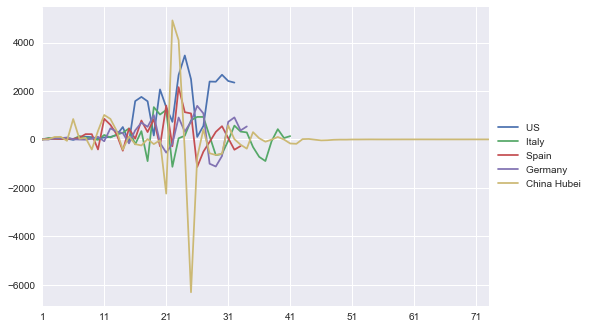

In [30]:
lineplot(df_2nd_derivative, 5)

In [31]:
def add_max_value_and_index(df):
    '''
    INPUT:
    df - pandas dataframe with timeseries
    
    OUTPUT:
    df - pandas dataframe which represents a derivative of the input dataframe
    
    Description:
    In the derivative for a timeseries, datapoint x is the differences of point x and x-1 from the input array.
    '''

    df_output=df.copy()
    
    # Sort according to the number of infections
    # Iterate over all rows in df and fill the user item data frame
    for index, row in df.iterrows():
        
        value_list=[]
        
        # Iterate over all columns
        for col_name, col_data in df.iteritems():
            if col_name!='Infections' and not(np.isnan(df_output.at[index, col_name])):
                value_list.append(df_output.at[index, col_name])

        max_value = max(value_list)
        max_index = value_list.index(max_value)
        
        df_output.at[index, 'max_value'] = max_value
        df_output.at[index, 'max_index'] = max_index

    return df_output

In [32]:
df_2nd_derivative=add_max_value_and_index(df_2nd_derivative)

In [33]:
df_2nd_derivative['growth_factor']=(df_2nd_derivative['max_value']/100)**(1/df_2nd_derivative['max_index'])

In [34]:
df_2nd_derivative

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,Infections,max_value,max_index,growth_factor
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
US,0.0,26.314286,2.785714e+01,26.400000,31.228571,-21.257143,70.114286,111.971429,93.857143,27.171429,82.057143,102.200000,175.828571,510.914286,-111.657143,1580.771429,1754.342857,1573.028571,159.942857,2.063229e+03,1332.428571,7.248000e+02,2655.085714,3464.857143,2.486143e+03,102.885714,557.542857,2388.228571,2.380571e+03,2668.571429,2411.114286,2345.285714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,275586.0,3464.857143,23.0,1.166656
Italy,0.0,59.400000,4.200000e+01,37.057143,55.914286,10.600000,138.914286,70.657143,34.514286,-18.628571,182.114286,82.142857,196.200000,273.142857,453.885714,-203.714286,341.600000,-896.942857,1332.857143,1.026029e+03,1216.714286,-1.131086e+03,46.371429,149.857143,7.872000e+02,928.657143,927.657143,133.685714,-6.491714e+02,-604.200000,-53.942857,570.514286,323.142857,288.171429,-313.857143,-720.571429,-893.400000,-74.057143,423.171429,57.857143,135.714286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,119827.0,1332.857143,18.0,1.154750
Spain,0.0,28.542857,2.457143e+01,20.314286,22.314286,23.028571,71.285714,218.342857,215.571429,-415.600000,851.657143,602.142857,212.542857,-466.942857,450.542857,27.228571,779.857143,303.142857,835.314286,-2.833714e+02,1396.485714,-2.829714e+02,2157.828571,1123.800000,1.072029e+03,-1136.514286,-504.942857,-102.800000,3.095429e+02,546.057143,53.657143,-426.571429,-273.428571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,119199.0,2157.828571,22.0,1.149839
Germany,0.0,-7.371429,5.871429e+01,50.228571,78.142857,4.942857,-5.428571,-11.514286,27.600000,107.200000,-77.371429,457.514286,320.942857,259.628571,-164.142857,372.600000,691.171429,520.314286,1002.742857,-1.407143e+02,-547.114286,-1.860286e+02,904.657143,318.285714,7.341714e+02,1386.057143,1071.000000,-1003.685714,-1.119686e+03,-684.514286,723.742857,908.285714,370.314286,534.571429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91159.0,1386.057143,25.0,1.110890
China Hubei,0.0,4.285714,1.001429e+02,105.085714,-59.085714,841.142857,27.542857,65.342857,-417.742857,351.314286,1008.857143,845.542857,356.800000,-422.857143,120.971429,-195.171429,-250.142857,13.142857,-194.657143,-3.662857e+01,-2238.257143,4.912800e+03,4096.914286,-469.714286,-6.308886e+03,-742.971429,419.228571,-572.400000,-6.434571e+02,-589.428571,577.685714,8.085714,-217.971429,-382.085714,300.971429,47.028571,-95.285714,-9.657143,101.571429,-6.000000,-168.457143,-181.942857,11.628571,18.314286,-12.457143,-40.514286,-3.325714e+01,-1.545714e+01,-9.057143,-9.485714,-3.114286e+00,-3.171429e+00,-1.085714e+00,1.714286e-01,-9.428571e-01,-1.371429,-1.371429e+00,-0.228571,-0.342857,0.085714,-8.571429e-02,4.285714e-01,0.142857,-0.142857,-4.285714e-01,8.571429e-02,0.000000e+00,0.000000e+00,-0.085714,0.428571,0.142857,-0.257143,-0.142857,67802.0,4912.800000,21.0,1.203759
France,0.0,30.942857,1.857143e+01,-3.057143,94.142857,104.371429,39.114286,-141.114286,87.200000,232.800000,-149.828571,211.857143,377.142857,-209.171429,124.657143,390.057143,336.571429,-224.657143,411.628571,4.568571e+01,-259.314286,8.550000e+02,531.885714,119.685714,-7.297143e+01,658.885714,691.771429,-576.457143,-3.578000e+02,1435.257143,1640.714286,-1582.485714,-736.857143,-1062.142857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,